<a href="https://colab.research.google.com/github/patjiang/openBind/blob/main/GeneratingBackbonesandAAseqs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Load Dependencies
%%time
import os, time, signal
import sys, random, string, re
if not os.path.isdir("params"):
  os.system("apt-get install aria2")
  os.system("mkdir params")
  # send param download into background
  os.system("(\
  aria2c -q -x 16 https://files.ipd.uw.edu/krypton/schedules.zip; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/6f5902ac237024bdd0c176cb93063dc4/Base_ckpt.pt; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/e29311f6f1bf1af907f9ef9f44b8328b/Complex_base_ckpt.pt; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; \
  touch params/done.txt) &")

if not os.path.isdir("RFdiffusion"):
  print("installing RFdiffusion...")
  os.system("git clone https://github.com/sokrypton/RFdiffusion.git")
  os.system("pip install jedi omegaconf hydra-core icecream pyrsistent pynvml decorator")
  os.system("pip install git+https://github.com/NVIDIA/dllogger#egg=dllogger")
  # 17Mar2024: adding --no-dependencies to avoid installing nvidia-cuda-* dependencies
  os.system("pip install --no-dependencies dgl==2.0.0 -f https://data.dgl.ai/wheels/cu121/repo.html")
  os.system("pip install --no-dependencies e3nn==0.3.3 opt_einsum_fx")
  os.system("cd RFdiffusion/env/SE3Transformer; pip install .")
  os.system("wget -qnc https://files.ipd.uw.edu/krypton/ananas")
  os.system("chmod +x ananas")

if not os.path.isdir("colabdesign"):
  print("installing ColabDesign...")
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@v1.1.1")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")

if not os.path.isdir("RFdiffusion/models"):
  print("downloading RFdiffusion params...")
  os.system("mkdir RFdiffusion/models")
  models = ["Base_ckpt.pt","Complex_base_ckpt.pt"]
  for m in models:
    while os.path.isfile(f"{m}.aria2"):
      time.sleep(5)
  os.system(f"mv {' '.join(models)} RFdiffusion/models")
  os.system("unzip schedules.zip; rm schedules.zip")

if 'RFdiffusion' not in sys.path:
  os.environ["DGLBACKEND"] = "pytorch"
  sys.path.append('RFdiffusion')

from google.colab import files
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import py3Dmol

from inference.utils import parse_pdb
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import fix_contigs, fix_partial_contigs, fix_pdb, sym_it
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.plot import plot_pseudo_3D

def get_pdb(pdb_code=None):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    if not os.path.isfile(f"{pdb_code}.pdb1"):
      os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz")
      os.system(f"gunzip {pdb_code}.pdb1.gz")
    return f"{pdb_code}.pdb1"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

def run_ananas(pdb_str, path, sym=None):
  pdb_filename = f"outputs/{path}/ananas_input.pdb"
  out_filename = f"outputs/{path}/ananas.json"
  with open(pdb_filename,"w") as handle:
    handle.write(pdb_str)

  cmd = f"./ananas {pdb_filename} -u -j {out_filename}"
  if sym is None: os.system(cmd)
  else: os.system(f"{cmd} {sym}")

  # parse results
  try:
    out = json.loads(open(out_filename,"r").read())
    results,AU = out[0], out[-1]["AU"]
    group = AU["group"]
    chains = AU["chain names"]
    rmsd = results["Average_RMSD"]
    print(f"AnAnaS detected {group} symmetry at RMSD:{rmsd:.3}")

    C = np.array(results['transforms'][0]['CENTER'])
    A = [np.array(t["AXIS"]) for t in results['transforms']]

    # apply symmetry and filter to the asymmetric unit
    new_lines = []
    for line in pdb_str.split("\n"):
      if line.startswith("ATOM"):
        chain = line[21:22]
        if chain in chains:
          x = np.array([float(line[i:(i+8)]) for i in [30,38,46]])
          if group[0] == "c":
            x = sym_it(x,C,A[0])
          if group[0] == "d":
            x = sym_it(x,C,A[1],A[0])
          coord_str = "".join(["{:8.3f}".format(a) for a in x])
          new_lines.append(line[:30]+coord_str+line[54:])
      else:
        new_lines.append(line)
    return results, "\n".join(new_lines)

  except:
    return None, pdb_str

def run(command, steps, num_designs=1, visual="none"):
  os.system("mkdir outputs/images")
  def run_command_and_get_pid(command):
    pid_file = '/dev/shm/pid'
    os.system(f'nohup {command} > /dev/null & echo $! > {pid_file}')
    with open(pid_file, 'r') as f:
      pid = int(f.read().strip())
    os.remove(pid_file)
    return pid
  def is_process_running(pid):
    try:
      os.kill(pid, 0)
    except OSError:
      return False
    else:
      return True

  run_output = widgets.Output()
  progress = widgets.FloatProgress(min=0, max=1, description='running', bar_style='info')
  display(widgets.VBox([progress, run_output]))

  # clear previous run
  for n in range(steps):
    if os.path.isfile(f"/dev/shm/{n}.pdb"):
      os.remove(f"/dev/shm/{n}.pdb")

  pid = run_command_and_get_pid(command)
  try:
    fail = False
    for j in range(num_designs):
      os.system(f"mkdir outputs/images/iteration_{j}")
      # for each step check if output generated
      for n in range(steps):
        wait = True
        while wait and not fail:
          time.sleep(0.1)
          if os.path.isfile(f"/dev/shm/{n}.pdb"):
            pdb_str = open(f"/dev/shm/{n}.pdb").read()
            if pdb_str[-3:] == "TER":
              wait = False
            elif not is_process_running(pid):
              fail = True
          elif not is_process_running(pid):
            fail = True

        if fail:
          progress.bar_style = 'danger'
          progress.description = "failed"
          break

        else:
          progress.value = (n+1) / steps
          if visual != "none":
            with run_output:
              run_output.clear_output(wait=True)
              if visual == "image":
                xyz, bfact = get_ca(f"/dev/shm/{n}.pdb", get_bfact=True)
                fig = plt.figure()
                fig.set_dpi(100);fig.set_figwidth(6);fig.set_figheight(6)
                ax1 = fig.add_subplot(111);ax1.set_xticks([]);ax1.set_yticks([])
                plot_pseudo_3D(xyz, c=bfact, cmin=0.5, cmax=0.9, ax=ax1)
                #plt.savefig(f'outputs/images/iteration_{j}/step_{n}.png')
                plt.show()
              if visual == "interactive":
                view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
                view.addModel(pdb_str,'pdb')
                view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
                view.zoomTo()
                view.show()
        if os.path.exists(f"/dev/shm/{n}.pdb"):
          os.remove(f"/dev/shm/{n}.pdb")
      if fail:
        progress.bar_style = 'danger'
        progress.description = "failed"
        break

    while is_process_running(pid):
      time.sleep(0.1)

  except KeyboardInterrupt:
    os.kill(pid, signal.SIGTERM)
    progress.bar_style = 'danger'
    progress.description = "stopped"

def run_diffusion(contigs, path, pdb=None, iterations=50,
                  symmetry="none", order=1, hotspot=None,
                  chains=None, add_potential=False,
                  num_designs=1, visual="none"):

  full_path = f"outputs/{path}"
  os.makedirs(full_path, exist_ok=True)
  opts = [f"inference.output_prefix={full_path}",
          f"inference.num_designs={num_designs}"]

  if chains == "": chains = None

  # determine symmetry type
  if symmetry in ["auto","cyclic","dihedral"]:
    if symmetry == "auto":
      sym, copies = None, 1
    else:
      sym, copies = {"cyclic":(f"c{order}",order),
                     "dihedral":(f"d{order}",order*2)}[symmetry]
  else:
    symmetry = None
    sym, copies = None, 1

  # determine mode
  contigs = contigs.replace(","," ").replace(":"," ").split()
  is_fixed, is_free = False, False
  fixed_chains = []
  for contig in contigs:
    for x in contig.split("/"):
      a = x.split("-")[0]
      if a[0].isalpha():
        is_fixed = True
        if a[0] not in fixed_chains:
          fixed_chains.append(a[0])
      if a.isnumeric():
        is_free = True
  if len(contigs) == 0 or not is_free:
    mode = "partial"
  elif is_fixed:
    mode = "fixed"
  else:
    mode = "free"

  # fix input contigs
  if mode in ["partial","fixed"]:
    pdb_str = pdb_to_string(get_pdb(pdb), chains=chains)
    if symmetry == "auto":
      a, pdb_str = run_ananas(pdb_str, path)
      if a is None:
        print(f'ERROR: no symmetry detected')
        symmetry = None
        sym, copies = None, 1
      else:
        if a["group"][0] == "c":
          symmetry = "cyclic"
          sym, copies = a["group"], int(a["group"][1:])
        elif a["group"][0] == "d":
          symmetry = "dihedral"
          sym, copies = a["group"], 2 * int(a["group"][1:])
        else:
          print(f'ERROR: the detected symmetry ({a["group"]}) not currently supported')
          symmetry = None
          sym, copies = None, 1

    elif mode == "fixed":
      pdb_str = pdb_to_string(pdb_str, chains=fixed_chains)

    pdb_filename = f"{full_path}/input.pdb"
    with open(pdb_filename, "w") as handle:
      handle.write(pdb_str)

    parsed_pdb = parse_pdb(pdb_filename)
    opts.append(f"inference.input_pdb={pdb_filename}")
    if mode in ["partial"]:
      iterations = int(80 * (iterations / 200))
      opts.append(f"diffuser.partial_T={iterations}")
      contigs = fix_partial_contigs(contigs, parsed_pdb)
    else:
      opts.append(f"diffuser.T={iterations}")
      contigs = fix_contigs(contigs, parsed_pdb)
  else:
    opts.append(f"diffuser.T={iterations}")
    parsed_pdb = None
    contigs = fix_contigs(contigs, parsed_pdb)

  if hotspot is not None and hotspot != "":
    opts.append(f"ppi.hotspot_res=[{hotspot}]")

  # setup symmetry
  if sym is not None:
    sym_opts = ["--config-name symmetry", f"inference.symmetry={sym}"]
    if add_potential:
      sym_opts += ["'potentials.guiding_potentials=[\"type:olig_contacts,weight_intra:1,weight_inter:0.1\"]'",
                   "potentials.olig_intra_all=True","potentials.olig_inter_all=True",
                   "potentials.guide_scale=2","potentials.guide_decay=quadratic"]
    opts = sym_opts + opts
    contigs = sum([contigs] * copies,[])

  opts.append(f"'contigmap.contigs=[{' '.join(contigs)}]'")
  opts += ["inference.dump_pdb=True","inference.dump_pdb_path='/dev/shm'"]

  print("mode:", mode)
  print("output:", full_path)
  print("contigs:", contigs)

  opts_str = " ".join(opts)
  cmd = f"./RFdiffusion/run_inference.py {opts_str}"
  print(cmd)

  # RUN
  run(cmd, iterations, num_designs, visual=visual)

  # fix pdbs
  for n in range(num_designs):
    pdbs = [f"outputs/traj/{path}_{n}_pX0_traj.pdb",
            f"outputs/traj/{path}_{n}_Xt-1_traj.pdb",
            f"{full_path}_{n}.pdb"]
    for pdb in pdbs:
      with open(pdb,"r") as handle: pdb_str = handle.read()
      with open(pdb,"w") as handle: handle.write(fix_pdb(pdb_str, contigs))

  return contigs, copies

installing RFdiffusion...
installing ColabDesign...
downloading RFdiffusion params...
CPU times: user 5.01 s, sys: 597 ms, total: 5.61 s
Wall time: 1min 34s


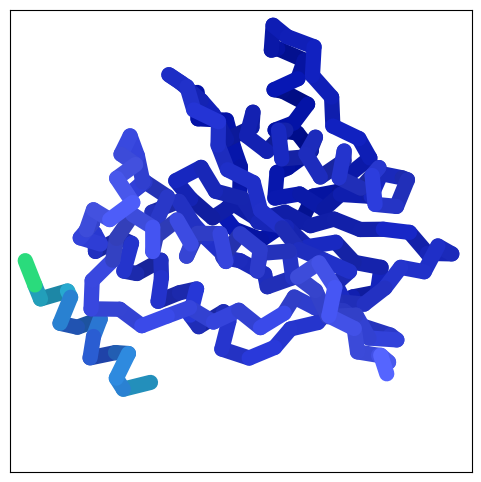

In [ ]:
%%time
#@title run **RFdiffusion** to generate a backbone
name = "iter21" #@param {type:"string"}
contigs = "A222-427:12-15" #@param {type:"string"}
#contigs = "A:7-15" #@param {type:"string"}
pdb = "" #@param {type:"string"}
iterations = 200 #@param ["25", "50", "100", "150", "200"] {type:"raw"}
hotspot = "A246,A247,A248,A249,A250,A251,A252,A253,A256,A260,A292,A293,A294,A295,A296,A297,A300,A301,A303,A304,A307,A308" #@param {type:"string"}
num_designs = 32 #@param ["1", "2", "4", "8", "16", "32"] {type:"raw"}
visual = "image" #@param ["none", "image", "interactive"]
#@markdown ---
#@markdown **symmetry** settings
#@markdown ---
symmetry = "none" #@param ["none", "auto", "cyclic", "dihedral"]
order = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] {type:"raw"}
chains = "" #@param {type:"string"}
add_potential = True #@param {type:"boolean"}
#@markdown - `symmetry='auto'` enables automatic symmetry detection with [AnAnaS](https://team.inria.fr/nano-d/software/ananas/).
#@markdown - `chains="A,B"` filter PDB input to these chains (may help auto-symm detector)


# determine where to save
path = name
while os.path.exists(f"outputs/{path}_0.pdb"):
  path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))



flags = {"contigs":contigs,
         "pdb":pdb,
         "order":order,
         "iterations":iterations,
         "symmetry":symmetry,
         "hotspot":hotspot,
         "path":path,
         "chains":chains,
         "add_potential":add_potential,
         "num_designs":num_designs,
         "visual":visual}

for k,v in flags.items():
  if isinstance(v,str):
    flags[k] = v.replace("'","").replace('"','')

contigs, copies = run_diffusion(**flags)

In [ ]:
#@title Display 3D structure {run: "auto"}
animate = "none" #@param ["none", "movie", "interactive"]
color = "chain" #@param ["rainbow", "chain", "plddt"]
denoise = True
dpi = 100 #@param ["100", "200", "400"] {type:"raw"}
from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca, get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

def plot_pdb(num=0):
  if denoise:
    pdb_traj = f"outputs/traj/{path}_{num}_pX0_traj.pdb"
  else:
    pdb_traj = f"outputs/traj/{path}_{num}_Xt-1_traj.pdb"
  if animate in ["none","interactive"]:
    hbondCutoff = 4.0
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    if animate == "interactive":
      pdb_str = open(pdb_traj,'r').read()
      view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    else:
      pdb = f"outputs/{path}_{num}.pdb"
      pdb_str = open(pdb,'r').read()
      view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    if color == "rainbow":
      view.setStyle({'cartoon': {'color':'spectrum'}})
    elif color == "chain":
      for n,chain,c in zip(range(len(contigs)),
                              alphabet_list,
                              pymol_color_list):
          view.setStyle({'chain':chain},{'cartoon': {'color':c}})
    else:
      view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
    view.zoomTo()
    if animate == "interactive":
      view.animate({'loop': 'backAndForth'})
    view.show()
  else:
    Ls = get_Ls(contigs)
    xyz, bfact = get_ca(pdb_traj, get_bfact=True)
    xyz = xyz.reshape((-1,sum(Ls),3))[::-1]
    bfact = bfact.reshape((-1,sum(Ls)))[::-1]
    if color == "chain":
      display(HTML(make_animation(xyz, Ls=Ls, dpi=dpi, ref=-1)))
    elif color == "rainbow":
      display(HTML(make_animation(xyz, dpi=dpi, ref=-1)))
    else:
      display(HTML(make_animation(xyz, plddt=bfact*100, dpi=dpi, ref=-1)))


if num_designs > 1:
  output = widgets.Output()
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
      options=[(f'{k}',k) for k in range(num_designs)],
      value=0, description='design:',
  )
  dropdown.observe(on_change)
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

# **What does plddt, i_ptm, i_pae,rmsd, mpnn mean?**
A Primer
plddt: per-residue measure of local confidence. It is scaled from 0 to 100, with higher scores indicating higher confidence and usually a more accurate prediction. pLDDT measures confidence in the local structure, estimating how well the prediction would agree with an experimental structure. It is based on the local distance difference test Cα (lDDT-Cα), which is a score that does not rely on superposition but assesses the correctness of the local distances


i_ptm:  ipTM measures the accuracy of the predicted relative positions of the subunits forming the protein-protein complex. Values higher than 0.8 represent confident high-quality predictions, while values below 0.6 suggest likely a failed prediction. ipTM values between 0.6 and 0.8 are a grey zone where predictions could be correct or wrong. These values assume modelling with multiple recycling steps, so the process of prediction reaches a degree of convergence.

i_pae: median predicted aligned error at the interface.  measure of how confident AlphaFold2 is in the relative position of two residues within the predicted structure. PAE is defined as the expected positional error at residue X, measured in Ångströms (Å), if the predicted and actual structures were aligned on residue Y.

rmsd: Root Mean Square Deviation. Measure of how different the Alphafold predicted struture of re-folded ProteinMPNN results are from the predicted structure given by RFDiffusion.

mpnn: negative log likelihood. Basically just a score of the model



tldr;
1.   Maximize plddt, i_ptm;
2.   Minimize i_pae, rmsd, mpnn



In [ ]:
%%time
#@title run **ProteinMPNN** to generate a sequence and **AlphaFold** to validate
num_seqs = 16 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
initial_guess = True #@param {type:"boolean"}
num_recycles = 3 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
use_multimer = True #@param {type:"boolean"}
rm_aa = "A" #@param {type:"string"}
mpnn_sampling_temp = 0.25 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
#@markdown - for **binder** design, we recommend `initial_guess=True num_recycles=3`

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]
if initial_guess: opts.append("--initial_guess")
if use_multimer: opts.append("--use_multimer")
opts = ' '.join(opts)
!python colabdesign/rf/designability_test.py {opts}

In [ ]:
#@title Display best result
import py3Dmol
def plot_pdb(num = "best"):
  if num == "best":
    with open(f"outputs/{path}/best.pdb","r") as f:
      # REMARK 001 design {m} N {n} RMSD {rmsd}
      info = f.readline().strip('\n').split()
    num = info[3]
  hbondCutoff = 4.0
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  pdb_str = open(f"outputs/{path}_{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  pdb_str = open(f"outputs/{path}/best_design{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})

  view.setStyle({"model":0},{'cartoon':{}}) #: {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.setStyle({"model":1},{'cartoon':{'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.zoomTo()
  view.show()

if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

In [ ]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive,
#@markdown try disabling your adblocker and run this cell again.
#@markdown  If that fails click on the little folder icon to the
#@markdown  left, navigate to file: `name.result.zip`,
#@markdown  right-click and select \"Download\"
#@markdown (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).
!zip -r {path}.result.zip outputs/{path}* outputs/traj/{path}*
files.download(f"{path}.result.zip")

In [ ]:
!zip -r {path}.images.zip outputs/images*
files.download(f"{path}.images.zip")